In [1]:
import glob
import matplotlib
import matplotlib.pyplot as plt
import pickle
import lmfit
import numpy as np
import scipy.stats as ss
plt.style.use('seaborn-white')
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.formula.api import ols, rlm
import sys
sys.path.append('../')
from Linearity import Neuron
from matplotlib import  rc
rc('text', usetex=True)

## 4 A Different models schematic 

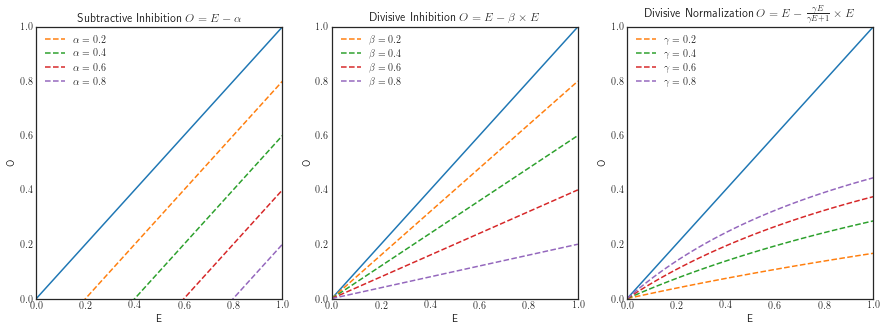

In [2]:
a = np.linspace(0,1,100)
f,ax = plt.subplots(1,3)

ax[0].plot(a, a)
ax[0].plot(a, a - 0.2, '--', label="$\\alpha = 0.2$")
ax[0].plot(a, a - 0.4, '--', label="$\\alpha = 0.4$")
ax[0].plot(a, a - 0.6, '--', label="$\\alpha = 0.6$")
ax[0].plot(a, a - 0.8, '--', label="$\\alpha = 0.8$")
ax[0].set_xlabel("E")
ax[0].set_ylabel("O")
ax[0].set_ylim((0,1))
ax[0].set_xlim((0,1))
ax[0].set_title("Subtractive Inhibition $O = E - \\alpha$")
ax[0].legend()

ax[1].plot(a, a)
ax[1].plot(a, a*0.8, '--', label="$\\beta = 0.2$")
ax[1].plot(a, a*0.6, '--', label="$\\beta = 0.4$")
ax[1].plot(a, a*0.4, '--', label="$\\beta = 0.6$")
ax[1].plot(a, a*0.2, '--', label="$\\beta = 0.8$")
ax[1].set_xlabel("E")
ax[1].set_ylabel("O")
ax[1].set_ylim((0,1))
ax[1].set_xlim((0,1))
ax[1].legend()
ax[1].set_title("Divisive Inhibition $O = E - \\beta \\times E$")

ax[2].plot(a, a)
ax[2].plot(a, 0.2*a/(0.2*a+1), '--', label="$\\gamma = 0.2$")
ax[2].plot(a, 0.4*a/(0.4*a+1), '--', label="$\\gamma = 0.4$")
ax[2].plot(a, 0.6*a/(0.6*a+1), '--', label="$\\gamma = 0.6$")
ax[2].plot(a, 0.8*a/(0.8*a+1), '--', label="$\\gamma = 0.8$")
ax[2].set_xlabel("E")
ax[2].set_ylabel("O")
ax[2].set_ylim((0,1))
ax[2].set_xlim((0,1))
ax[2].legend()
ax[2].set_title("Divisive Normalization $O = E - \\frac{ \\gamma E}{ \\gamma E + 1} \\times E $")
f.set_figwidth(15)
f.set_figheight(5)
plt.show()

In [3]:
currentClampFiles = '/media/sahil/NCBS_Shares_BGStim/patch_data/current_clamp_files.txt'
with open (currentClampFiles,'r') as r:
    dirnames = r.read().splitlines()

In [4]:
feature = 0
scalingFactor = 1e9
neurons = {}
for dirname in dirnames:
    cellIndex = dirname.split('/')[-2]
    filename = dirname + 'plots/' + cellIndex + '.pkl'
    n = Neuron.load(filename)
    neurons[str(n.date) + '_' + str(n.index)] = n

In [5]:
#Colorscheme for squares
color_sqr = { index+1: color for index, color in enumerate(matplotlib.cm.viridis(np.linspace(0,1,9)))}

In [6]:
control_result2_rsquared_adj = []
control_result1_rsquared_adj = []
control_var_expected = []
gabazine_result2_rsquared_adj = []
gabazine_result1_rsquared_adj = []
gabazine_var_expected = []
tolerance = 5e-4

In [7]:
def linearModel(x, a=1):
    # Linear model
    return (a*x)

def DN_model(x,a=1):
    # Divisive normalization model
    #return x - a*(x**2)/(b+x)
    return x/(a*x+1)

## 4 B Divisive Normalization representative cell

In [8]:
feature = 0 # Area under the curve
neuron = neurons['170303_c1']
expected, observed, g_expected, g_observed = {}, {}, {}, {}
for expType, exp in neuron:
    ## Control case
    if(expType == "Control"):
        for sqr in exp:
            if sqr > 1:
                expected[sqr] = []
                observed[sqr] = []
                for coord in exp[sqr].coordwise:
                    for trial in exp[sqr].coordwise[coord].trials:
                        if all([value == 0 for value in trial.flags.values()]):
                            expected[sqr].append(exp[sqr].coordwise[coord].expected_feature[feature])
                            observed[sqr].append(trial.feature[feature])

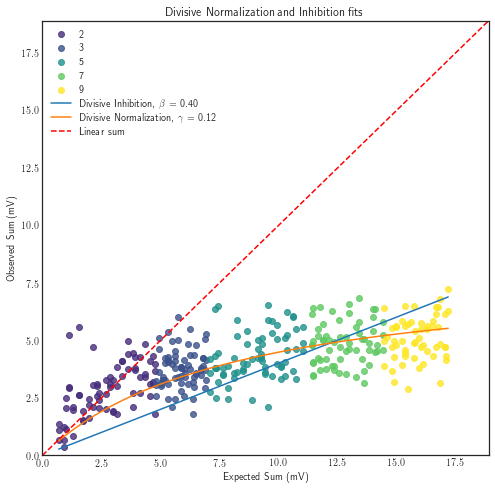

In [9]:
lin_aic = []
dn_aic = []
lin_chi = []
dn_chi = []
max_exp, max_g_exp = 0.,0.
f, ax = plt.subplots()
squareVal = []
list_control_expected = []
list_control_observed = []

for sqr in sorted(observed):
    squareVal.append(ax.scatter(expected[sqr], observed[sqr], label=str(sqr), c=color_sqr[sqr], alpha=0.8))
    max_exp = max(max_exp, max(expected[sqr]))
    list_control_expected += expected[sqr]
    list_control_observed += observed[sqr]
    
X = np.array(list_control_expected)
y = np.array(list_control_observed)
idx   = np.argsort(X)
X = X[idx]
y = y[idx]

linear_Model = lmfit.Model(linearModel)
DN_Model = lmfit.Model(DN_model)

lin_pars = linear_Model.make_params()
lin_result = linear_Model.fit(y, lin_pars, x=X)
lin_aic.append(lin_result.aic)
lin_chi.append(lin_result.redchi)

DN_pars = DN_Model.make_params()
DN_result = DN_Model.fit(y, DN_pars, x=X)
dn_aic.append(DN_result.aic)
dn_chi.append(DN_result.redchi)

# print (lin_result.fit_report())
# print (DN_result.fit_report())

ax.set_xlim(xmin=0.)
ax.set_ylim(ymin=0.)
ax.set_xlabel("Expected")
ax.set_ylabel("Observed")
ax.set_title("Divisive Normalization and Inhibition fits")
div_inh = ax.plot(X, lin_result.best_fit, '-')
div_norm = ax.plot(X, DN_result.best_fit, '-')


max_exp *=1.1
max_g_exp *=1.1
ax.set_xlim(0,max_exp)
ax.set_ylim(0,max_exp)
ax.set_xlabel("Expected Sum (mV)")
ax.set_ylabel("Observed Sum (mV)")
linear = ax.plot((0,max_exp), (0,max_exp), 'r--')

legends = squareVal + div_inh + div_norm + linear
labels = sorted(observed.keys()) + ["Divisive Inhibition, $\\beta$ = {:.2f}".format(lin_result.params['a'].value), "Divisive Normalization, $\\gamma$ = {:.2f}".format(DN_result.params['a'].value), "Linear sum"]

f.set_figwidth(8)
f.set_figheight(8)
ax.legend(legends, labels)
plt.show()

### 2 cells not working check them out.

In [10]:
neurons.pop('150904_c3', None)
neurons.pop('160126_c3', None)

<Linearity.Neuron instance at 0x7fe989f7db00>

In [11]:
feature = 0 # Area under the curve
lin_bic = []
dn_bic = []
lin_chi = []
dn_chi = []
beta = []
gamma = []
for index in neurons:
#     print (index)
    neuron = neurons[index]
    expected, observed, g_expected, g_observed = {}, {}, {}, {}
    for expType, exp in neuron:
        ## Control case
        if(expType == "Control"):
            for sqr in exp:
                if sqr > 1:
                    expected[sqr] = []
                    observed[sqr] = []
                    for coord in exp[sqr].coordwise:
                        for trial in exp[sqr].coordwise[coord].trials:
                            if all([value == 0 for value in trial.flags.values()]):
                                expected[sqr].append(exp[sqr].coordwise[coord].expected_feature[feature])
                                observed[sqr].append(trial.feature[feature])

            max_exp, max_g_exp = 0.,0.

            squareVal = []
            list_control_expected = []
            list_control_observed = []

            for sqr in sorted(observed):
                squareVal.append(ax.scatter(expected[sqr], observed[sqr], label=str(sqr), c=color_sqr[sqr], alpha=0.8))
                max_exp = max(max_exp, max(expected[sqr]))
                list_control_expected += expected[sqr]
                list_control_observed += observed[sqr]

            X = np.array(list_control_expected)
            y = np.array(list_control_observed)
            idx   = np.argsort(X)
            X = X[idx]
            y = y[idx]

            linear_Model = lmfit.Model(linearModel)
            DN_Model = lmfit.Model(DN_model)

            lin_pars = linear_Model.make_params()
            lin_result = linear_Model.fit(y, lin_pars, x=X)
            lin_bic.append(lin_result.bic)
            lin_chi.append(lin_result.redchi)
            beta.append(lin_result.params['a'])

            DN_pars = DN_Model.make_params()
            DN_result = DN_Model.fit(y, DN_pars, x=X)
            dn_bic.append(DN_result.bic)
            dn_chi.append(DN_result.redchi)
            gamma.append(DN_result.params['a'])

170317_c3
170317_c1
170317_c4
160209_c4
161123_c2_CS
160223_c3
160223_c2
161117_c3_CS
161228_c1
170124_c3_CS
160830_c1
161116_c2
160219_c5
170208_c3
Control_RS_short_3_c1_150929
161110_c1
161117_c2_CS
170124_c2_CS
RS_TBS_short_5_c4_160122
161117_c1
161026_c1
170303_c1
161027_c3
160920_c1
160927_c1
160927_c3
161013_c1
160927_c5
Control_RS_short_2_c1_150828
150904_c1
161116_c1_CS
170104_c4
Control_RS_short_6_c2_160513
170220_c1
170222_c2
170222_c1
161109_c3
150828_c2
160928_c3
160928_c4
161123_c1_CS
160617_c5
150902_c1
150902_c2
160817_c2
Control_RS_short_1_c4_150827
160513_c5


## 4 C (Chi-squares population)

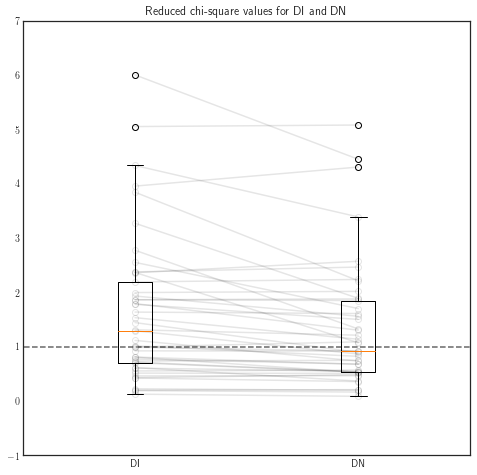

In [17]:
indices = [1,2]
fig, ax = plt.subplots()
for ind, (l,d) in enumerate(zip(lin_chi, dn_chi)):
    ax.plot(indices, [l,d], 'o-', alpha=0.1, color='k', markerfacecolor='white')
# ax.violinplot([lin_chi,dn_chi], indices)
ax.boxplot([lin_chi,dn_chi] )
ax.hlines(1, 0,3, linestyles='--', alpha=0.6)
# ax.boxplot(, [1])

# ax.set_xlim((-1,2))
ax.set_ylim((-1,7))
ax.set_xticks(indices)
ax.set_xticklabels(('DI', 'DN'))
ax.set_title("Reduced chi-square values for DI and DN")
fig.set_figheight(8)
fig.set_figwidth(8)
plt.show()

## 4 D (BIC Population)

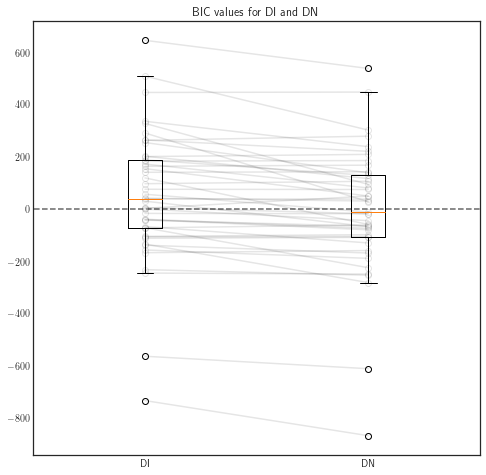

In [18]:
indices = [1,2]
fig, ax = plt.subplots()
for ind, (l,d) in enumerate(zip(lin_bic, dn_bic)):
    ax.plot(indices, [l,d], 'o-', alpha=0.1, color='k', markerfacecolor='white')
# ax.violinplot(lin_chi, [0])
# ax.violinplot(dn_chi, [1])
ax.boxplot([lin_bic,dn_bic] )
# ax.set_ylim((-1,7))
ax.hlines(0, 0,3, linestyles='--', alpha=0.6)
ax.set_xticks(indices)
ax.set_xticklabels(('DI', 'DN'))
ax.set_title("BIC values for DI and DN")
plt.legend()
fig.set_figheight(8)
fig.set_figwidth(8)
plt.show()

## 4 E (DN Fit parameter gamma)

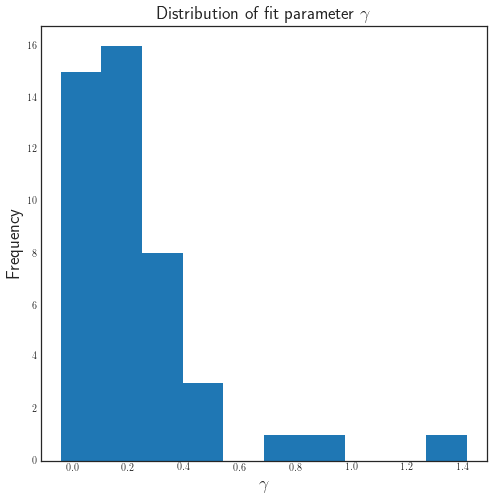

In [19]:
fig, ax = plt.subplots()
# bins = 10
ax.hist(gamma)
# ax.set_xlim(-1,2)
ax.set_xlabel("$\\gamma$", fontsize=18)
ax.set_ylabel("Frequency", fontsize=18)
ax.set_title("Distribution of fit parameter $\\gamma$", fontsize=18)
plt.legend()
fig.set_figheight(8)
fig.set_figwidth(8)
plt.show()

In [ ]:
## Not using

In [ ]:
# fig, ax = plt.subplots()
# bins = 15
# ax.hist(beta, bins=bins, label="$\\beta$")
# plt.legend()
# fig.set_figheight(8)
# fig.set_figwidth(8)
# plt.show()

In [ ]:
# lin_aic = []
# dn_aic = []
# lin_chi = []
# dn_chi = []

# control_observed = {}
# control_observed_average = {}
# gabazine_observed ={}
# gabazine_observed_average = {}
# control_expected = {}
# control_expected_average = {}
# gabazine_expected ={}
# gabazine_expected_average = {}
# feature = 0

# neuron = Neuron.load(filename)
# for expt in neuron.experiment:
#     print ("Starting expt {}".format(expt))
#     for numSquares in neuron.experiment[expt].keys(): 
#         print ("Square {}".format(numSquares))
#         if not numSquares == 1:
#             nSquareData = neuron.experiment[expt][numSquares]
#             if expt == "Control":
#                 coords_C = nSquareData.coordwise
#                 for coord in coords_C: 
#                     if feature in coords_C[coord].feature:
#                         control_observed_average.update({coord: coords_C[coord].average_feature[feature]})
#                         control_expected_average.update({coord: coords_C[coord].expected_feature[feature]})
#                         control_observed.update({coord: []})
#                         control_expected.update({coord: []})
#                         for trial in coords_C[coord].trials:
#                             if feature in trial.feature:
#                                 control_observed[coord].append(trial.feature[feature])
#                                 control_expected[coord].append(coords_C[coord].expected_feature[feature])
#             elif expt == "GABAzine":
#                 coords_I = nSquareData.coordwise
#                 for coord in coords_I: 
#                     if feature in coords_I[coord].feature:
#                         gabazine_observed.update({coord: []})
#                         gabazine_expected.update({coord: []})
#                         gabazine_observed_average.update({coord: coords_I[coord].average_feature[feature]})
#                         gabazine_expected_average.update({coord: coords_I[coord].expected_feature[feature]})

#                         for trial in coords_I[coord].trials:
#                             if feature in trial.feature:
#                                 gabazine_observed[coord].append(trial.feature[feature])
#                                 gabazine_expected[coord].append(coords_I[coord].expected_feature[feature])
# print ("Read {} into variables".format(filename))